## Dropout

Dropout is a regularization technique used to prevent overfitting in neural networks.

During training, dropout randomly “drops out” (sets to zero) a fraction of the neuron activations in a layer.
This forces the network to not rely too heavily on any single neuron. It encourages redundancy and robustness in the learned features.

## Definition: Dropout

Input
* $x \in \mathbb{R}^{d_{in}}$ 

Parameter:
* drop probability $p$

Output
* $\text{Dropout}_{p}(x)=x$

Training Output:
* $\text{TrainDropout}_{p}(x) = \frac{1}{1-p}m*x$ 

where $m$ is a $d_{in}$-vector of i.i.d Bernoulli random variables 
$$m_i\sim \operatorname{Bernoulli}(1-p), \quad i=1,2,\dots,d_{in}.$$
called mask.


### Property: 
$$\mathbb{E}[\operatorname{TrainDropout}_p(x)]=\operatorname{Id}(x)=\operatorname{Dropout}_p(x).$$
$$

Proof: Let's take $i=1,2,\dots,d_{in}$:
$$ 
\begin{align*}
\mathbb{E}[\operatorname{TrainDropout}_p(x)]_i&=\mathbb{E}\left[\frac{1}{1-p}m_ix_i\right],\\
&=\frac{1}{1-p}\mathbb{E}\left[m_i\right]x_i,\\
&=\frac{1}{1-p}(p \cdot 0+ 1 \cdot (1-p))x_i,\\
&=x_i.
\end{align*}
$$
Then $\mathbb{E}[\operatorname{TrainDropout}_p(x)]=x$

**Note:** Dropout can be interpreted as training an implicit ensemble of many smaller subnetworks, each defined by a dropout mask $k\in\{0,1\}^{d_{in}}$, where $k_i=1$ means the $i$-th neuron is kept and $k_i=0$ means the $i$-th neuron is dropped. These $k$-subnetworks share parameters and are not trained independently and not for the same amount of epoch s either. 
The probability of the $k$-subnetwork is trained in an epoach, is
$$
\begin{align*}
P(m=k)&=\prod_{i=1}^{d_{in}}(1-p)^{k_i}p^{1-k_i}=\left(1-p\right)^{\sum_{i=1}^{d_{in}}k_i}p^{d_{in}-\sum_{i=1}^{d_{in}}k_i},\\
&=\left(1-p\right)^{n_{\text{kept}}(k)}p^{d_{in}-n_{\text{kept}}(k)},\\
&=p^{d_{in}}\left(\frac{1}{p}-1\right)^{n_{\text{kept}}(k)},
\end{align*}
$$
where $n_{\text{kept}}(k)=\sum_{i=1}^{d_{in}}k_i$ is the number of neuron kept in the mask $k$.
Then, the number of epoach the $k$-subnetwork is trained is:
$$n(k)\sim \text{Bin}\left(N,P(m=k)\right)$$
where $N$ is the total number of training epoachs.
Then, the expected value of the number of epoachs the $k$-subnetwork is trained is: 
$$\mathbb{E}[n(k)] = P(m=k)N=p^{d_{in}}\left(\frac{1}{p}-1\right)^{n_{\text{kept}}(k)}N.$$
Notice that, depending on the values of the dropping probabilty $p$, we have
$$p\begin{cases}
<\frac{1}{2},& \mathbb{E}[n(k)] \text{ increases with } n_{\text{kept}}(k),\\
=\frac{1}{2},& \mathbb{E}[n(k)]=p^{d_{in}} \text{ for all } k,\\
>\frac{1}{2},& \mathbb{E}[n(k)] \text{ decreases with } n_{\text{kept}}(k).
\end{cases}
$$
Therefore, dropout can be seen as a weighted average trainning of a ensamble  of subnetworks, that, when $p<\frac{1}{2}$ as usual, weighted more (train during more epoachs) the network masks that have more actvie neurons.

In practice, no single configuration is visited many times for large $d_{\text{in}}$ (for $M$ dropout layers we have $2^{\sum_{i=1}^Md_{in,i}}$ subnetworks), instead, the expectation defines the effective contribution to training.

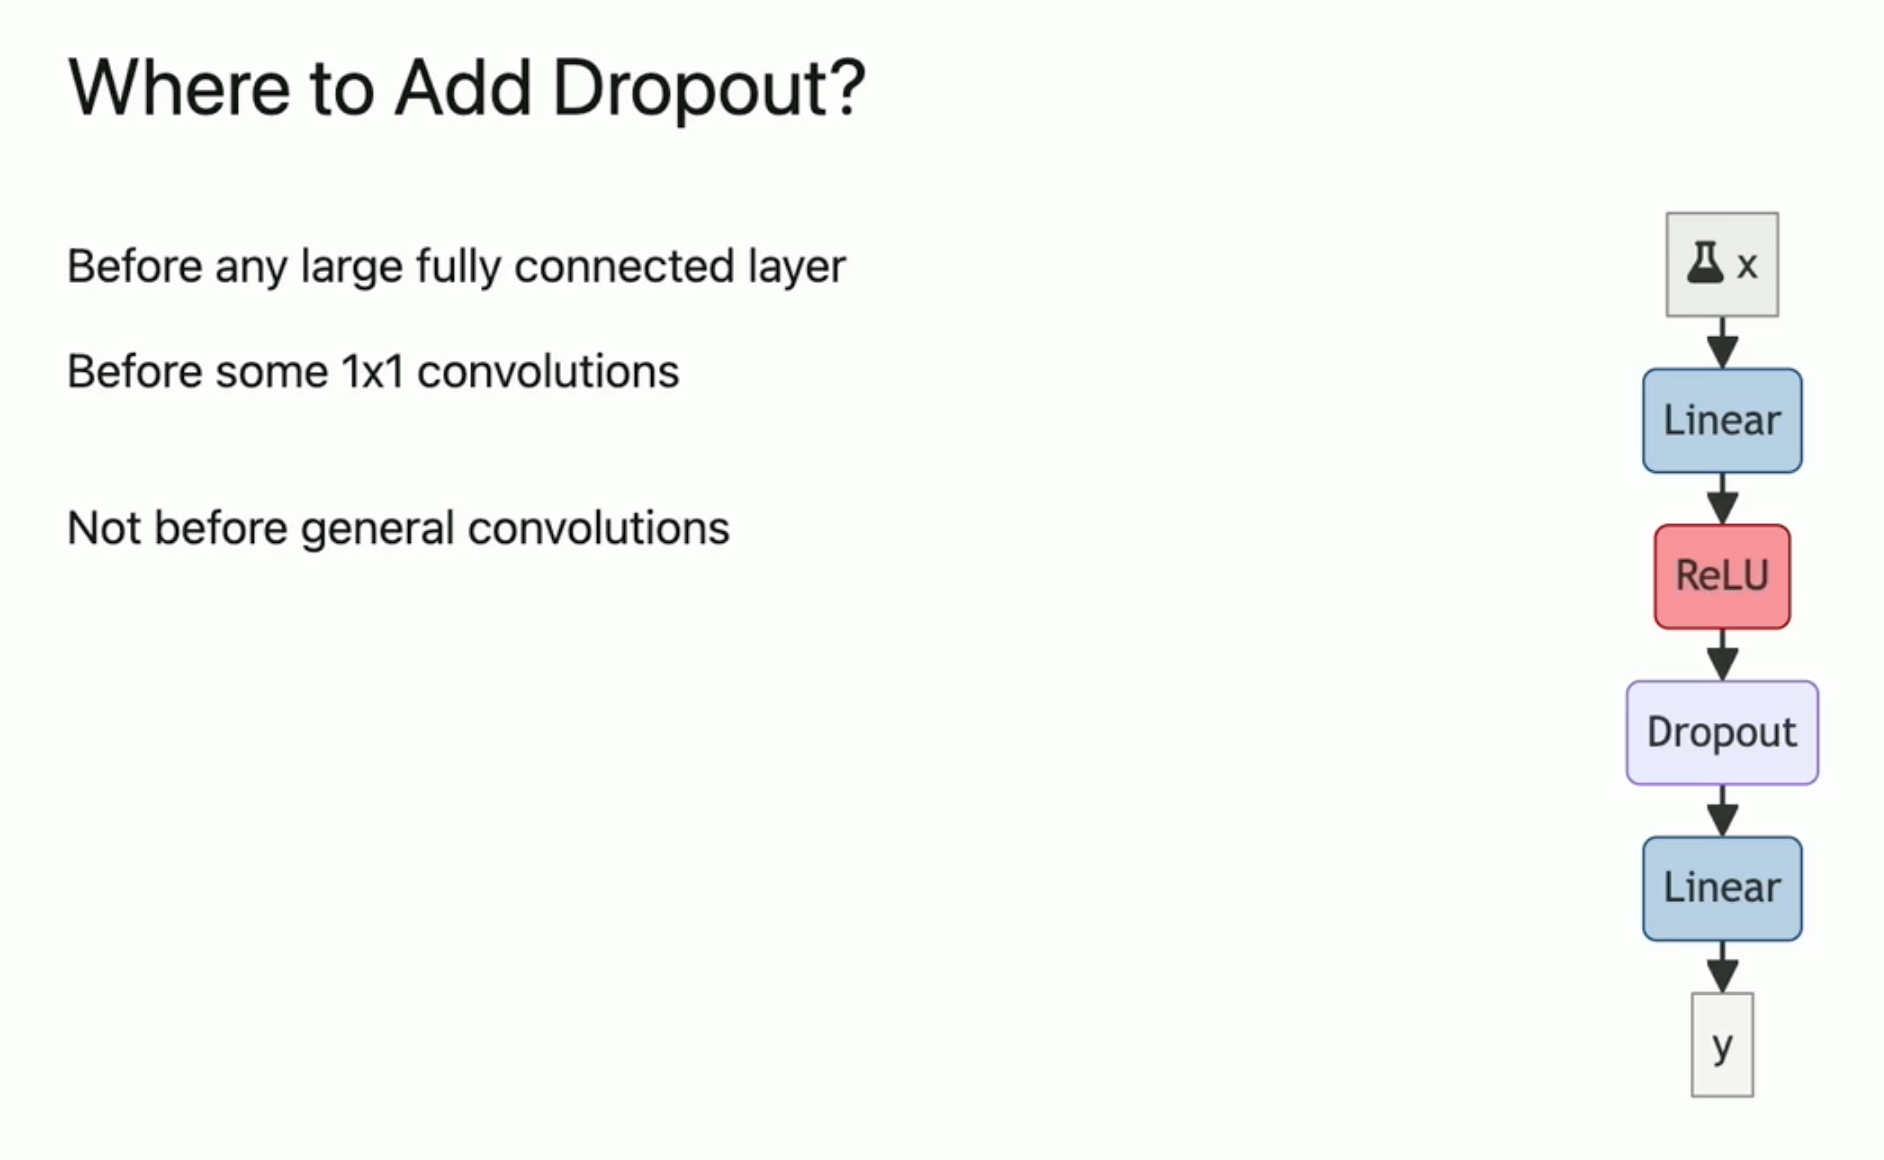

## Code: Dropout

In [1]:
import torch
import torch.nn as nn

In [183]:
class Dropout(nn.Module):
    def __init__(self, p: float = 0.5):
        """
        p: drop probability (0 <= p < 1)
        """
        super().__init__()
        assert 0.0 <= p < 1.0, "p must be in [0, 1)"
        self.p = p
        self.keep_prob = 1.0 - self.p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # If we are in eval mode, dropout does nothing
        if not self.training or self.p == 0.0:
            return x
        ## this match PyTorch's nn.Dropout random behavior
        mask = torch.empty_like(x, dtype=torch.float32)
        mask = mask.bernoulli_(self.keep_prob)
        return x * mask / self.keep_prob

## Testing

In [171]:
in_dim = 4
out_dim = 3
p = 0.1

batch_size = 2

In [178]:
x = torch.randn(batch_size, in_dim)

In [173]:
x/(1-p)

tensor([[-0.7992, -0.4482, -0.6629,  0.2023],
        [-0.9519,  1.2229, -1.1902,  0.1363]])

### Training output

In [176]:
nn_drop = nn.Dropout(p=p)
torch.manual_seed(0)
nn_drop(x)

tensor([[-0.0000, -0.4482, -0.6629,  0.0000],
        [-0.9519,  1.2229, -1.1902,  0.1363]])

In [177]:
drop=Dropout(p=p)
torch.manual_seed(0)
drop(x)

tensor([[-0.0000, -0.4482, -0.6629,  0.0000],
        [-0.9519,  1.2229, -1.1902,  0.1363]])

### Evaluation output

In [179]:
x

tensor([[-0.7193, -0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712,  0.1227]])

In [181]:
nn_drop.eval()
nn_drop(x)

tensor([[-0.7193, -0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712,  0.1227]])

In [182]:
drop.eval()
drop(x)

tensor([[-0.7193, -0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712,  0.1227]])